<a href="https://colab.research.google.com/github/sharifshars/Deep-learning-Chest-Opacity-Detection/blob/main/Chest_Opacities_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
from tensorflow import keras
from keras import layers
import os
import numpy as np
from keras.applications.vgg19 import preprocess_input
import csv


In [41]:
# Path to the images
path_to_images ="/content/drive/MyDrive/Dataset/dataset1/known_images"

In [42]:
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    path_to_images,
    class_names= ["Normal","Sick"],
    batch_size =32,
    image_size =(395, 488),
    validation_split =0.2,
    subset = "both",
    seed=200
)

Found 715 files belonging to 2 classes.
Using 572 files for training.
Using 143 files for validation.


In [43]:
#instantiating and freesing the VGG19 convolutional base
conv_base = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top= False,
    input_shape =(395, 488, 3)
)

# conv_base.trainable = False

In [44]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []

  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg19.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)

    all_features.append(features)
    all_labels.append(labels)

  return np.concatenate(all_features), np.concatenate(all_labels)

In [45]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(val_dataset)

1/1 [==============================] - 42s 42s/step


In [50]:
train_features.shape

(572, 12, 15, 512)

In [53]:
inputs = keras.Input(shape=(12,15, 512))

x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [98]:
model.compile(
    loss = "binary_crossentropy",
    optimizer="adam",
    metrics=[keras.metrics.Accuracy(), keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()]
)

In [99]:
callbacks=[
    keras.callbacks.ModelCheckpoint(
        filepath="chest_opacities_detection_with_Vgg19.keras",
        save_best_only=True,
        monitor ="val_loss"
    )
]

In [100]:
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/30
18/18 [==============================] - 16s 851ms/step - loss: 1.2699 - accuracy: 0.9685 - auc_6: 0.9859 - precision_6: 0.9828 - recall_6: 0.9896 - val_loss: 2.0592 - val_accuracy: 0.9720 - val_auc_6: 0.9777 - val_precision_6: 0.9836 - val_recall_6: 0.9677
Epoch 2/30
18/18 [==============================] - 9s 478ms/step - loss: 1.5278 - accuracy: 0.9703 - auc_6: 0.9773 - precision_6: 0.9825 - recall_6: 0.9723 - val_loss: 4.4057 - val_accuracy: 0.9720 - val_auc_6: 0.9815 - val_precision_6: 0.9538 - val_recall_6: 1.0000
Epoch 3/30
18/18 [==============================] - 8s 455ms/step - loss: 0.9310 - accuracy: 0.9843 - auc_6: 0.9913 - precision_6: 0.9931 - recall_6: 0.9896 - val_loss: 3.3544 - val_accuracy: 0.9860 - val_auc_6: 0.9877 - val_precision_6: 0.9688 - val_recall_6: 1.0000
Epoch 4/30
18/18 [==============================] - 10s 572ms/step - loss: 2.0799 - accuracy: 0.9755 - auc_6: 0.9860 - precision_6: 0.9861 - recall_6: 0.9827 - val_loss: 1.8823 - val_accuracy: 0.

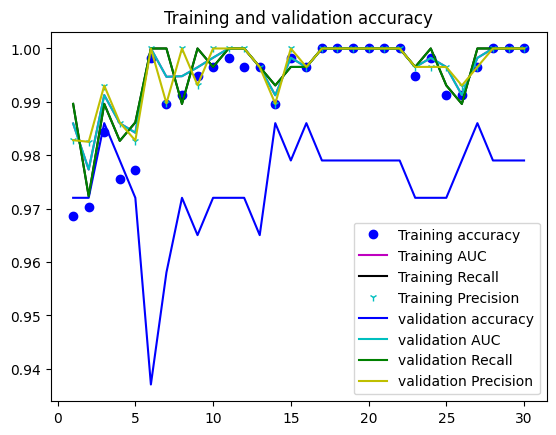

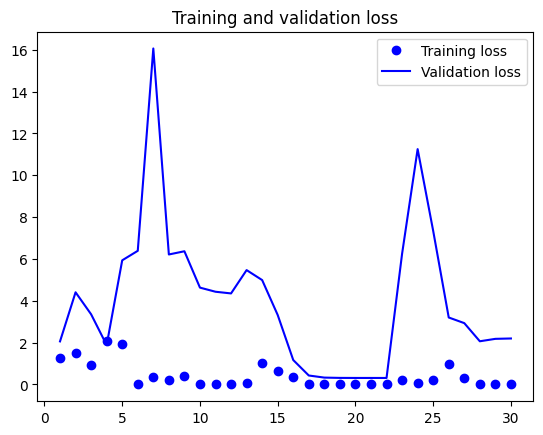

In [101]:
import matplotlib.pyplot as plt

# Training accuracy
acc = history.history["accuracy"]
auc = history.history["auc_6"]
precision = history.history["precision_6"]
recall = history.history["recall_6"]

# Validation accuracy
val_acc = history.history["val_accuracy"]
val_auc = history.history["auc_6"]
val_precision = history.history["precision_6"]
val_recall = history.history["recall_6"]

# loss
loss=history.history["loss"]
val_loss =history.history["val_loss"]
epochs = range(1,len(acc)+1)

#Accuracy plots
plt.plot(epochs, acc,"bo", label = "Training accuracy")
plt.plot(epochs, auc,"m", label = "Training AUC")
plt.plot(epochs, recall,"k", label = "Training Recall")
plt.plot(epochs, precision,"c1", label = "Training Precision")

plt.plot(epochs,val_acc, "b", label ="validation accuracy")
plt.plot(epochs,val_auc, "c", label ="validation AUC")
plt.plot(epochs,val_recall, "g", label ="validation Recall")
plt.plot(epochs,val_precision, "y", label ="validation Precision")

plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

#loss plot
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [103]:
model = keras.models.load_model("/content/chest_opacities_detection_with_Vgg19.keras")
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 12, 15, 512)]     0         
                                                                 
 flatten_3 (Flatten)         (None, 92160)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               23593216  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23,593,473
Trainable params: 23,593,473
Non-trainable params: 0
_________________________________________________________________


In [104]:
# Define the directory containing the test images
test_dir = "/content/drive/MyDrive/Dataset/dataset1/unknown_images"

# Get the list of test image file paths
test_image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

In [105]:
# Create an empty array to store predictions and file names
predictions_with_filenames = []

# Loop through each test image, make predictions and store the predicted label
for image_path in test_image_paths:
    # Load the image and resize it to the target size
    img = keras.preprocessing.image.load_img(image_path, target_size = (395, 488))

    # Convert the image to a numpy array
    img_array = keras.preprocessing.image.img_to_array(img)

    # Expand the dimensions of the array to create a batch axis
    img_array = np.expand_dims(img_array, axis=0)

    # prep
    img_array = keras.applications.vgg19.preprocess_input(img_array)

    
    features = conv_base.predict(img_array)

    # Make predictions on the image
    predictions = model.predict(features)
    

    # Convert the predictions to a binary label (0 for Normal, 1 for Sick)
    predicted_label = int(predictions[0] > 0.5)

    # Extract the file name from the image path
    file_name = os.path.basename(image_path)

    # Add the predicted label and file name to the list
    predictions_with_filenames.append((file_name, predicted_label))

1/1 [==============================] - 0s 44ms/step


In [106]:
# Save the predictions with file names as a CSV file
with open('/content/chest_opacities_detection_Sharif_Kiggundu.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Add name and registration number to file
    writer.writerow(['Name:', 'Kiggundu Sharif'])
    writer.writerow(['Registration Number:', '2022/HD05/1213U'])
    writer.writerow(['File Name', 'Predicted Label'])
    for prediction in predictions_with_filenames:
        writer.writerow(prediction)

In [107]:
path_to_dataset_2 = "/content/drive/MyDrive/Dataset/dataset2/images"

In [108]:
test_dataset = keras.utils.image_dataset_from_directory(
    path_to_dataset_2,
    class_names=["Normal", "Sick"],
    batch_size = 32,
    image_size=(395, 488),
)

Found 224 files belonging to 2 classes.


In [109]:
test_model = keras.models.load_model("/content/chest_opacities_detection_with_Vgg19.keras")

In [111]:
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 91s 91s/step


In [113]:
 test_results = test_model.evaluate(test_features, test_labels)

7/7 [==============================] - 1s 122ms/step - loss: 850.9597 - accuracy: 0.4464 - auc_6: 0.4504 - precision_6: 0.4739 - recall_6: 0.8929


In [114]:
print(test_results)

[850.9596557617188, 0.4464285671710968, 0.4504145681858063, 0.4739336371421814, 0.8928571343421936]
